In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing import load_SDD, load_and_window_SDD, get_reference_image
from utils.image_utils import create_dist_mat, get_patch, sampling, image2world
from eval import get_future_samples
from tqdm import tqdm
import seaborn as sns
import subprocess
import glob
import pdb
from multiprocessing import Pool
import yaml
from model import YNet
import warnings
from torch.serialization import SourceChangeWarning
from darts import TimeSeries
from darts.models.forecasting.random_forest import RandomForest
from darts.models.forecasting.varima import VARIMA
from darts.models.forecasting.arima import ARIMA
warnings.filterwarnings('ignore', category=SourceChangeWarning)

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [2]:
scene = 'nexus_4' # demathCircle_1 is longest I know of
mode = 'train'
OBS_LEN = 10  # in timesteps
PRED_LEN = 80  # in timesteps
DOWNSAMPLE_FACTOR_TRAINING = 1
TRAIN_LEN = (OBS_LEN + PRED_LEN + 1)
frames, annotations, _ = load_SDD(scene, mode=mode, load_frames=True)
annotations.drop(['sceneId'], axis=1, inplace=True)
annotations.set_index('frame', inplace=True)

loading train data
Parsing scene: nexus_4
Processing video...


1062it [00:37, 28.53it/s]


Processing annotations


In [3]:
# Get darts series for each agent
series = []
mids = []
noise = 1e-1
for mid in annotations.metaId.unique():
    anns = annotations[annotations.metaId==mid]
    try:
        curr_anns = annotations[annotations.metaId==mid][['x','y']]
        curr_anns.x = curr_anns.x + np.random.randn(len(curr_anns.x))
        curr_anns.y = curr_anns.y + np.random.randn(len(curr_anns.y))
        series += [ TimeSeries.from_dataframe(curr_anns, value_cols=['x', 'y']) ]
        mids += [ mid ]
    except:
        print(f"Failed for metaId: {mid}")

# Get longest series
series_lengths = [ len(s) for s in series ]
imax = series_lengths.index(max(series_lengths))
mid_max = mids[imax]

ValueError: Could not convert integer index to a pd.RangeIndex. Found non-unique step sizes/frequencies: {1, 180}. If any of those is the actual frequency, try passing it with fill_missing_dates=True and freq=your_frequency.


Failed for metaId: 38


In [4]:
from joblib import Parallel, delayed

def forecast_model(m):
    model = VARIMA(p=10,d=1,trend='c')
    verbose = True
    retrain = True
    mid = mids[m]
    if len(series[m]) <= OBS_LEN + PRED_LEN: # Series is too short
        print("Too short")
        return None
    forecasts = [ fc.pd_dataframe() for fc in model.historical_forecasts(series[m], forecast_horizon=PRED_LEN, train_length=50, last_points_only=False, enable_optimization=True, retrain=retrain, verbose=verbose) ]
    if len(forecasts) == 0: # Series is too short
        print("No forecasts")
        return None
    for j in range(len(forecasts)):
        forecasts[j]['ahead'] = np.arange(PRED_LEN) + 1
        forecasts[j].rename({"x" : "pred_x", "y": "pred_y"}, axis=1, inplace=True)
        forecasts[j] = forecasts[j].reset_index()
        forecasts[j].frame = forecasts[j].frame.min() - 1
    forecasts = pd.concat(forecasts)
    forecasts['metaId'] = mid
    return forecasts

prediction_df = Parallel(n_jobs=-1)(delayed(forecast_model)(m) for m in range(len(mids)))
prediction_df = [df for df in prediction_df if df is not None]

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost`

Too short


  7%|▋         | 51/702 [05:00<47:30,  4.38s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  8%|▊         | 56/672 [05:00<39:39,  3.86s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to 

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 57%|█████▋    | 80/141 [05:01<03:42,  3.65s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 57%|█████▋    | 81/141 [05:01<03:53,  3.89s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to 

No forecasts


  7%|▋         | 52/702 [05:03<45:17,  4.18s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 57/672 [05:04<39:28,  3.85s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to 

Too short


 23%|██▎       | 61/263 [05:05<25:29,  7.57s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 59/792 [05:05<46:37,  3.82s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 77/342 [05:06<13:16,  3.00s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 57%|█████▋    | 81/141 [05:05<03:46,  3.78s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/states

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 33%|███▎      | 81/242 [05:07<10:10,  3.79s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|█████▊    | 82/141 [05:09<03:41,  3.75s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

No forecasts


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 79/342 [05:12<12:48,  2.92s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|▉         | 80/833 [05:11<1:09:32,  5.54s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|███▍      | 84/242 [05:13<0

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|▉         | 81/822 [05:15<44:49,  3.63s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 34%|███▍      | 83/242 [05:15<10:07,  3.82s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 16%|█▌        | 83/521 [05:15<29:22,  4.02s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWar

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|███▌      | 85/242 [05:17<09:44,  3.72s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 66/281 [05:18<13:58,  3.90s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to 

Too short


 18%|█▊        | 85/464 [05:18<30:16,  4.79s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 69/556 [05:19<32:42,  4.03s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|▉         | 82/822 [05:18<45:16,  3.67s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary 

Too short


/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 60%|██████    | 85/141 [05:21<03:34,  3.83s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  9%|▊         | 76/872 [05:21<50:36,  3.81s/it]/home/aa/miniconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

In [5]:
# Save out dataframe
prediction_df_concatenated = pd.concat(prediction_df, axis=0, ignore_index=True)
all_data = pd.merge(
    annotations,
    prediction_df_concatenated,
    on=['frame','metaId']
)
os.makedirs('./processed_data/darts/', exist_ok=True)
all_data.to_csv('./processed_data/darts/' + scene + '.csv')

14640      1320.033434
14641      1320.368952
14642      1322.141620
14643      1320.564397
14644      1323.445730
              ...     
1047115    1064.664959
1047116    1064.528115
1047117    1064.602226
1047118    1064.378650
1047119    1064.333442
Name: pred_y, Length: 1360, dtype: float64


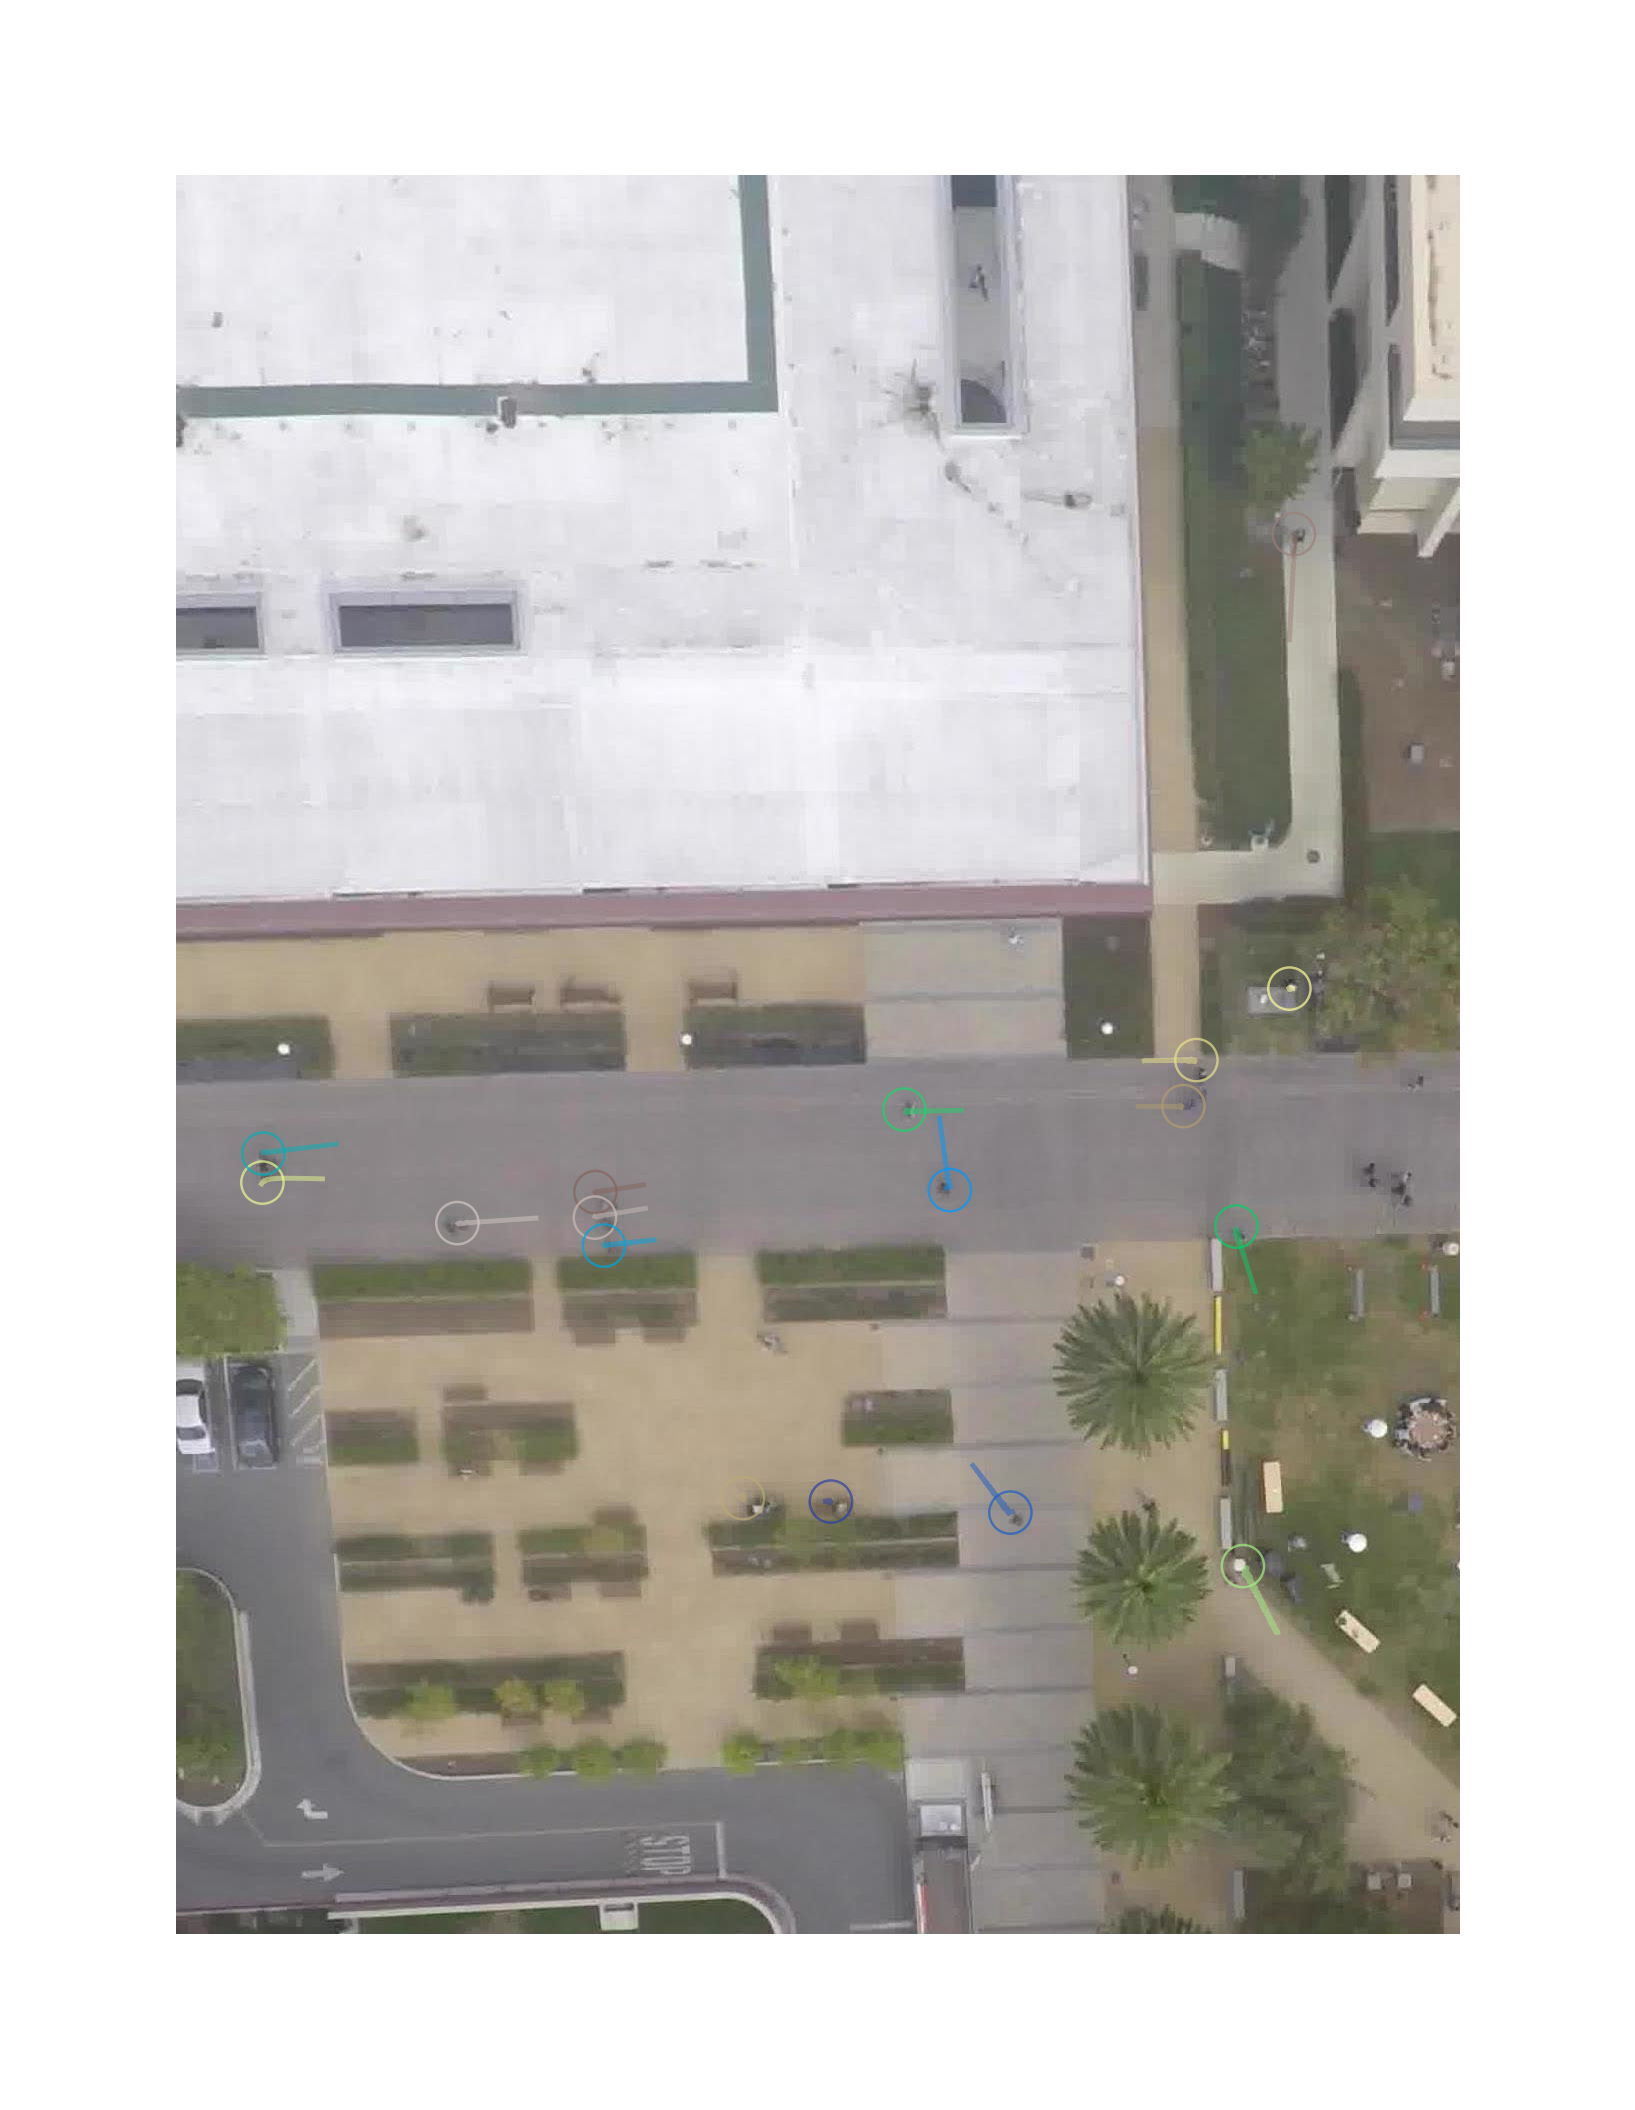

In [6]:
df = all_data
frame_idx = 300
cmap = plt.get_cmap('terrain')
cmap_lut = cmap(np.random.permutation(np.linspace(0, 1, df.metaId.max()+1)))
frame = frames[frame_idx]
fig = plt.figure()
fig.set_size_inches(1. * frame.shape[1] / frame.shape[0], 1, forward = False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
for mid in mids:
    local_df = df[(df.frame == frame_idx) & (df.metaId== mid)]
    if len(local_df) == 0:
        continue
    ax.scatter(local_df.x.iloc[0], local_df.y.iloc[0], facecolor="none", edgecolor=cmap_lut[mid], s=3, linewidths=0.1, alpha=0.7)
    ax.plot(local_df.pred_x, local_df.pred_y, color=cmap_lut[mid], alpha=0.5, linewidth=0.2)
plt.gcf().set_dpi(frame.shape[0])
ax.imshow(frame)
print(df[df.frame == frame_idx].pred_y)